
    
### Маркетинговый анализ развлекательного приложения Procrastinate Pro+.
    
    Цель проекта: выяснить причины убытков компании.
    Задачи проекта:
    1. Выяснить с каких каналов рекламы приходят пользователи и какими устройствами пользуются
    2. Стоимость привлечения пользователей из различных рекламных каналов
    3. Выручка каждого клиента
    4. Окупаемость рекламы 
    5. Причины неокупаемости рекламы
    
</div>
    

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
visits['Session Start'] = pd.to_datetime(visits['Session Start'])

In [5]:
visits['Session End'] = pd.to_datetime(visits['Session End'])

In [6]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [7]:
display(visits.duplicated().sum())

0

In [8]:
orders = pd.read_csv('/datasets/orders_info_short.csv')

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [10]:
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])

In [11]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [12]:
display(orders.duplicated().sum())

0

In [13]:
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [15]:
costs['dt'] = pd.to_datetime(costs['dt'], format = '%Y-%m-%d').dt.date

In [16]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [17]:
display(costs.duplicated().sum())

0

Во всех файлах отсутствуют пропуски и дубликаты

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.


In [18]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['User Id', 'Session Start']], on='User Id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['Session Start'] - result_raw['first_ts']
    ).dt.days

    # яфункция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='User Id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'User Id': 'nunique'})
            .rename(columns={'User Id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержани
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [19]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['User Id', 'Event Dt'])
        .groupby('User Id')
        .agg({'Event Dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['User Id', 'Event Dt']], on='User Id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['Event Dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='User Id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'User Id': 'nunique'})
            .rename(columns={'User Id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [20]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['User Id', 'Event Dt', 'Revenue']], on='User Id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['Event Dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='Revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'User Id': 'nunique'})
            .rename(columns={'User Id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['User Id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Функции LTV, ROI, удержания, конверсии заданы

### Исследовательский анализ данных

- Составление профилей пользователей. Минимальная и максимальная даты привлечения пользователей.
- Из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построение таблицы, отражающую количество пользователей и долю платящих из каждой страны.
- Какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построение таблицы, отражающую количество пользователей и долю платящих для каждого устройства.
- Рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построение таблицы, отражающую количество пользователей и долю платящих для каждого канала привлечения.


In [21]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['User Id', 'Session Start'])
        .groupby('User Id')
        .agg(
            {
                'Session Start': 'first',
                'Channel': 'first',
                'Device': 'first',
                'Region': 'first',
            }
        )
        .rename(columns={'Session Start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['User Id'].isin(orders['User Id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'Channel'])
        .agg({'User Id': 'nunique'})
        .rename(columns={'User Id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'Channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'Channel', 'acquisition_cost']],
        on=['dt', 'Channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [22]:
profiles = get_profiles(visits, orders, costs)
profiles.head(10)

,User Id,first_ts,Channel,Device,Region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


In [23]:
min_analysis_date = profiles['dt'].min()
observation_date =  profiles['dt'].max()

In [24]:
min_analysis_date

datetime.date(2019, 5, 1)

In [25]:
observation_date

datetime.date(2019, 10, 27)

In [26]:
horizon_days = 14  # горизонт анализа 

Минимальная дата привлечения пользователей - 1 мая 2019 года.
Максимальная дата привлечения пользователей - 27 октября 2019 года.

In [27]:
region_payer_share = pd.DataFrame()
region_payer_share['users_cnt'] = profiles.groupby('Region')['User Id'].count()
region_payer_share['payer_users_cnt'] = profiles.query('payer == True').groupby('Region')['User Id'].count()
region_payer_share['share'] = 100*(region_payer_share['payer_users_cnt'] / region_payer_share['users_cnt'])
region_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_cnt,payer_users_cnt,share
Region,,,
United States,100002,6902,6.9%
Germany,14981,616,4.1%
UK,17575,700,4.0%
France,17450,663,3.8%


 Больше всего платящих пользователей в Соединенных Штатах.

In [28]:
device_payer_share = pd.DataFrame()
device_payer_share['users_cnt'] = profiles.groupby('Device')['User Id'].count()
device_payer_share['payer_users_cnt'] = profiles.query('payer == True').groupby('Device')['User Id'].count()
device_payer_share['share'] = ((device_payer_share['payer_users_cnt'] / device_payer_share['users_cnt']))*100
device_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_cnt,payer_users_cnt,share
Device,,,
Mac,30042,1912,6.4%
iPhone,54479,3382,6.2%
Android,35032,2050,5.9%
PC,30455,1537,5.0%


Больше всего платящих пользователей используют Mac (6.4%) и iPhone (6.2%)

In [29]:
channel_payer_share = pd.DataFrame()
channel_payer_share['users_cnt'] = profiles.groupby('Channel')['User Id'].count()
channel_payer_share['payer_users_cnt'] = profiles.query('payer == True').groupby('Channel')['User Id'].count()
channel_payer_share['share'] = ((channel_payer_share['payer_users_cnt'] / channel_payer_share['users_cnt']))*100
channel_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_cnt,payer_users_cnt,share
Channel,,,
FaceBoom,29144,3557,12.2%
AdNonSense,3880,440,11.3%
lambdaMediaAds,2149,225,10.5%
TipTop,19561,1878,9.6%
RocketSuperAds,4448,352,7.9%
WahooNetBanner,8553,453,5.3%
YRabbit,4312,165,3.8%
MediaTornado,4364,156,3.6%
LeapBob,8553,262,3.1%


Больше всего платящих пользователей пришло из каналов FaceBoom (12,2%), AdNonSense (11,3%), lambdaMediaAds (10,5%)

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируйте динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [30]:
costs['costs'].sum().round(2)

105497.3

In [31]:
channel_costs = pd.DataFrame()
channel_costs['costs'] = costs.groupby('Channel')['costs'].sum().round(2)
channel_costs['share'] = ((channel_costs['costs'] / costs['costs'].sum()))*100
channel_costs.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,costs,share
Channel,,
TipTop,54751.300000,51.9%
FaceBoom,32445.600000,30.8%
WahooNetBanner,5151.000000,4.9%
AdNonSense,3911.250000,3.7%
OppleCreativeMedia,2151.250000,2.0%
RocketSuperAds,1833.000000,1.7%
LeapBob,1797.600000,1.7%
lambdaMediaAds,1557.600000,1.5%
MediaTornado,954.480000,0.9%


Общая сумма расходов на рекламу: 105497,3
Больше всего средств потрачено на рекламу в TipTop и FaceBoom (82,7%)

In [32]:
costs['date'] = pd.to_datetime(costs['dt'])

In [33]:
costs['week'] = costs['date'].dt.isocalendar().week

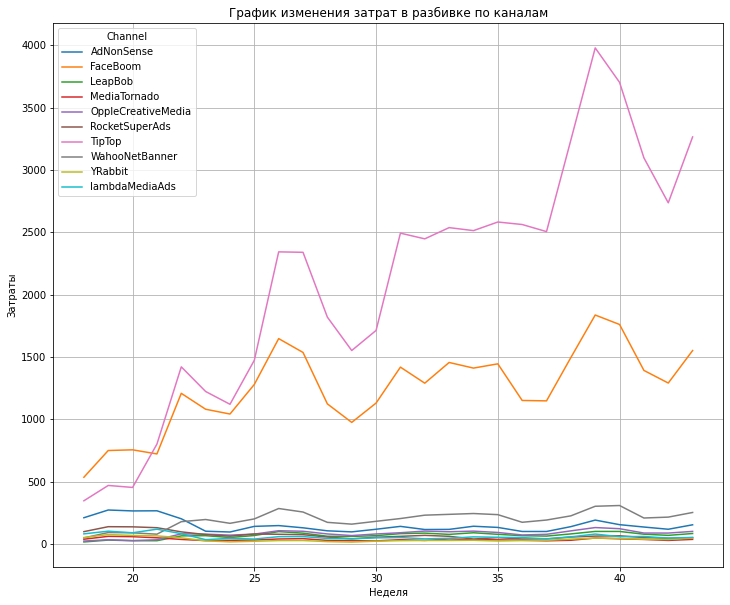

In [34]:
filtered_data = costs.pivot_table(
        index='week', columns='Channel', values='costs', aggfunc='sum'
    )
filtered_data.plot(                                             
           figsize=(12, 10),
           grid=True,)

plt.title('График изменения затрат в разбивке по каналам')
plt.xlabel('Неделя')
plt.ylabel('Затраты')
plt.show()

In [35]:
costs['month'] = costs['date'].dt.month

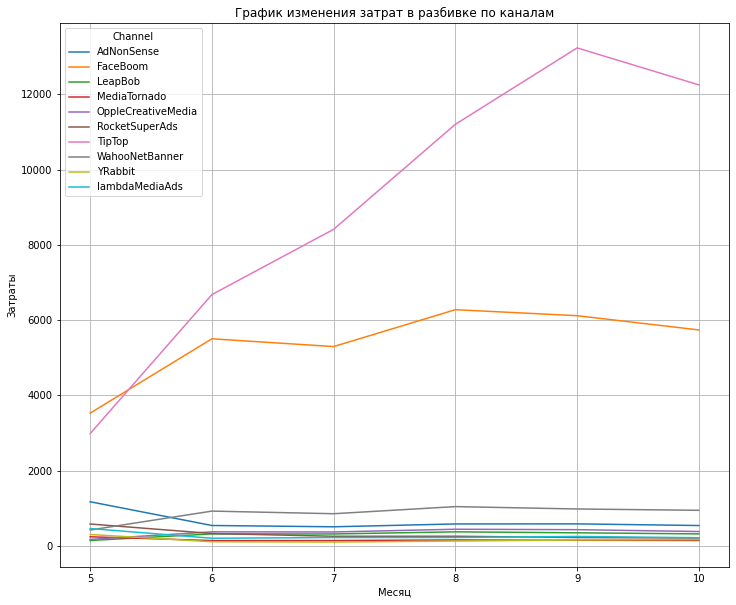

In [36]:
filtered_data = costs.pivot_table(
        index='month', columns='Channel', values='costs', aggfunc='sum'
    )
filtered_data.plot(                                             
           figsize=(12, 10),
           grid=True,)

plt.title('График изменения затрат в разбивке по каналам')
plt.xlabel('Месяц')
plt.ylabel('Затраты')
plt.show()

По графикам видно, что скачок затрат на рекламу в TipTop - это сентябрь, 39-я неделя.

In [37]:
cac_channel = pd.DataFrame()
profiles = profiles.query('Channel != "organic"')
cac_channel['acquisition_cost_mean'] = profiles.groupby('Channel')['acquisition_cost'].mean()
cac_channel.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

,acquisition_cost_mean
Channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Стоимость привлечения одного пользователя гораздо выше в TipTop	

In [38]:
profiles['acquisition_cost'].mean().round(2)

1.13

### Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Вывод, возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

In [39]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [40]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

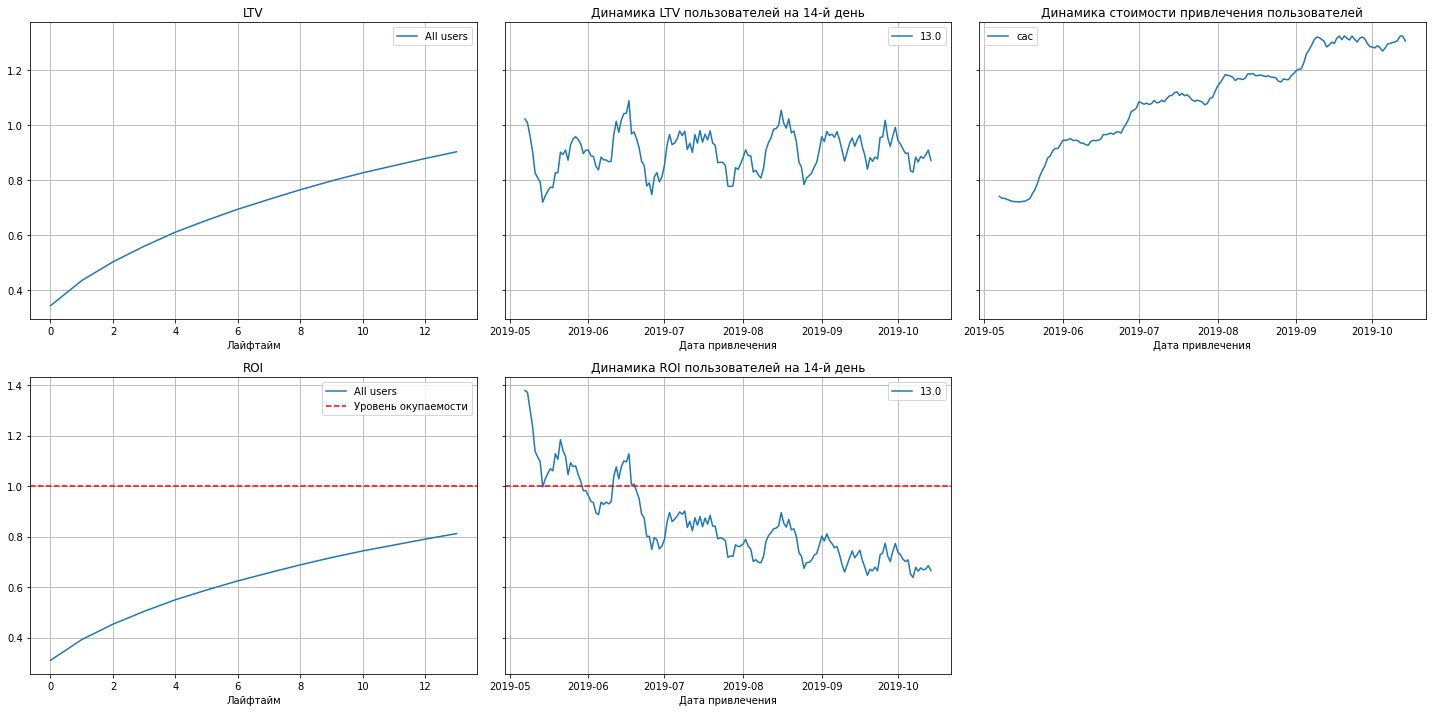

In [41]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Вывод:
1. LTV держится на примерно одном уровне 
2. CAC на протяжении всего периода растёт
3. ROI не доходит до уровня окупаемости.
4. Пользователи перестают окупаться уже в середине июня

In [42]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

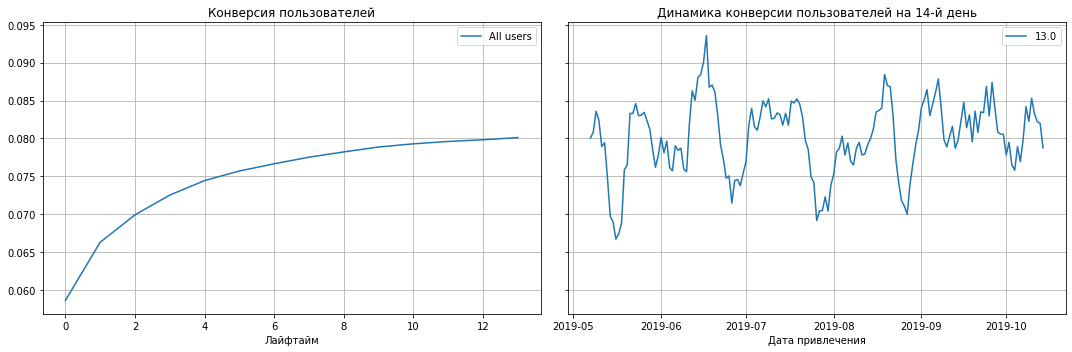

In [43]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия пользователей замирает на одном уровне с увеличением лайфтайма. Динамика конверсии показывает, что выше всего конверсия у пользователей, привлеченных в середине июня.

In [44]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

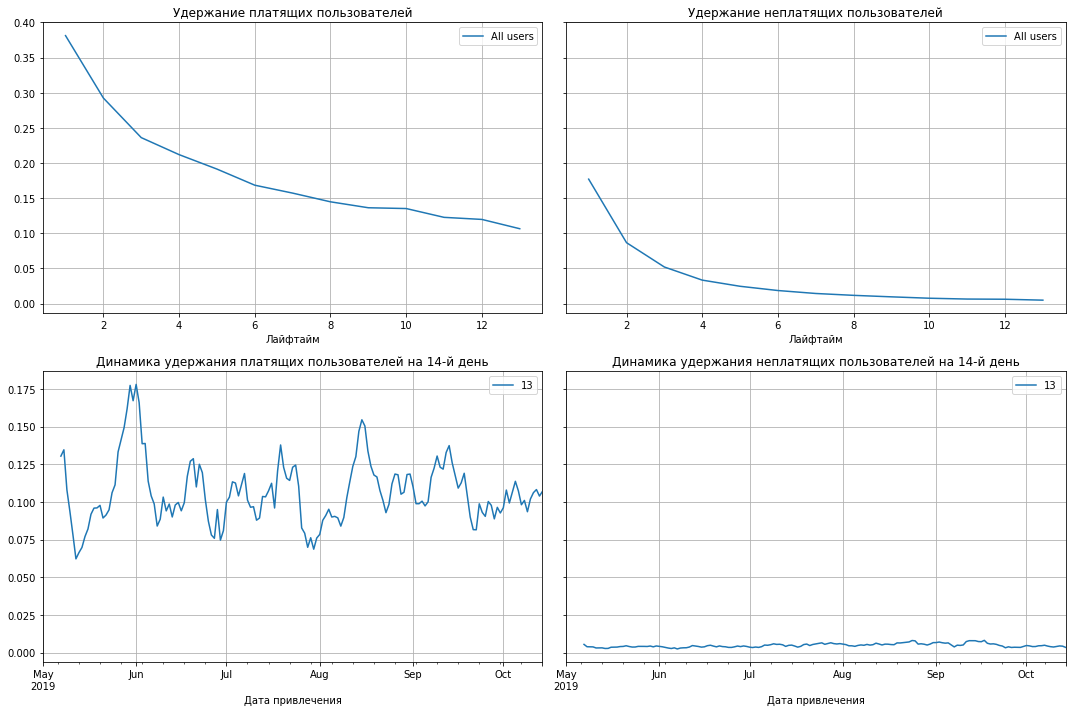

In [45]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

На графиках видно, что удержание платящих пользователей выше, чем неплатящих. Динамика удержания платящих пользователей на 14 день выше у пользователей, привлеченных в конце мая. Динамика удержания неплатящих пользователей примерно одинакова для всего периода.

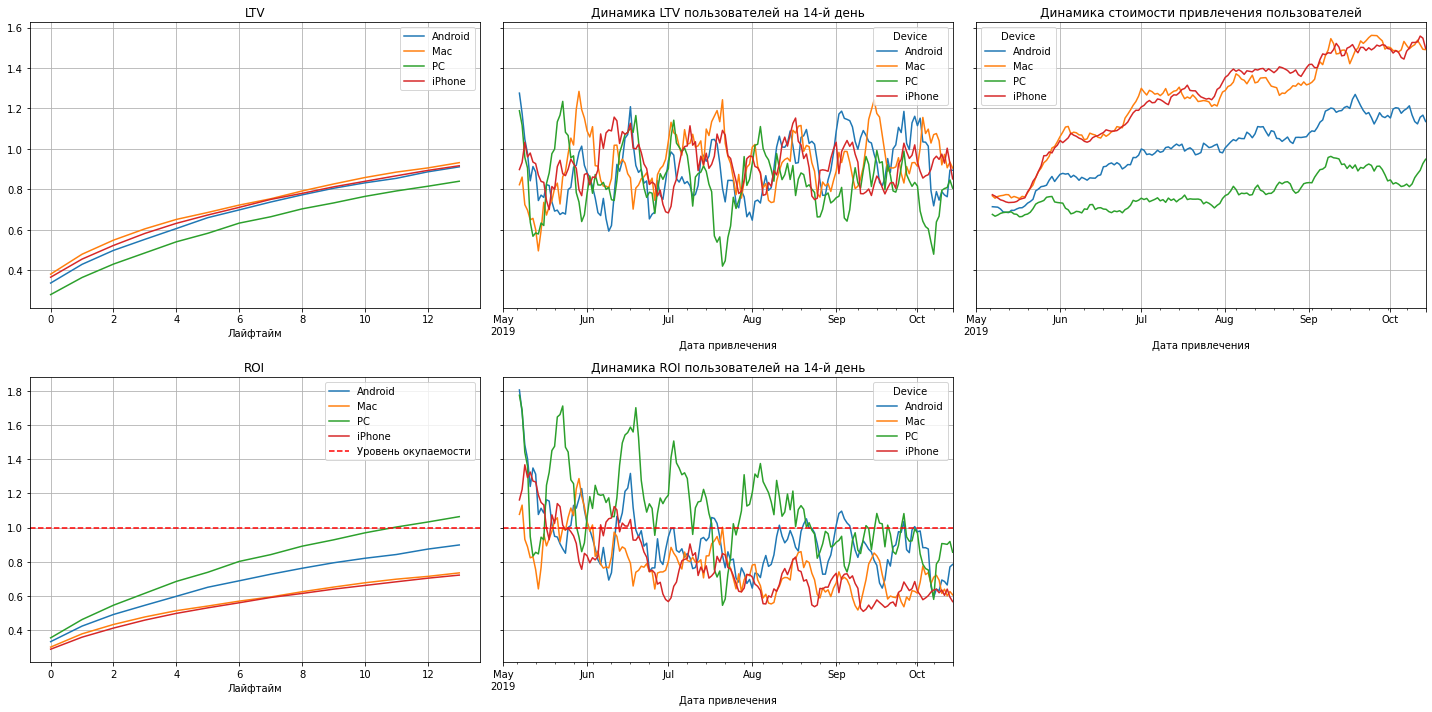

In [46]:
dimensions = ['Device']
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

LTV пользоватлей на всех устройствах примерно одинаковый. Однако только у пользователей, работающих на устройствах РС, реклама окупается.

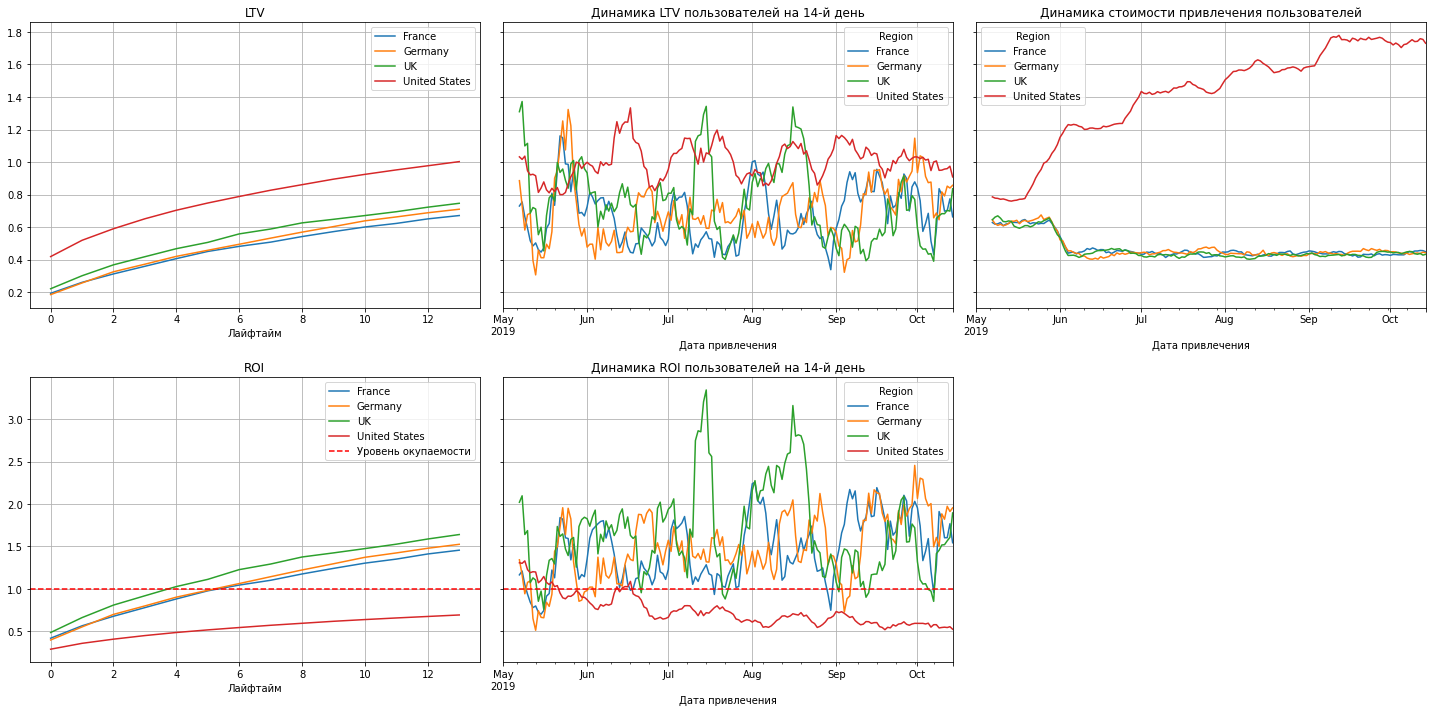

In [47]:
dimensions = ['Region']
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

LTV пользователей из США выше, чем издругих стран, однако реклама не окупается. У пользователей из Франции, Германии, Великобритании затраты на рекламу окупаются.

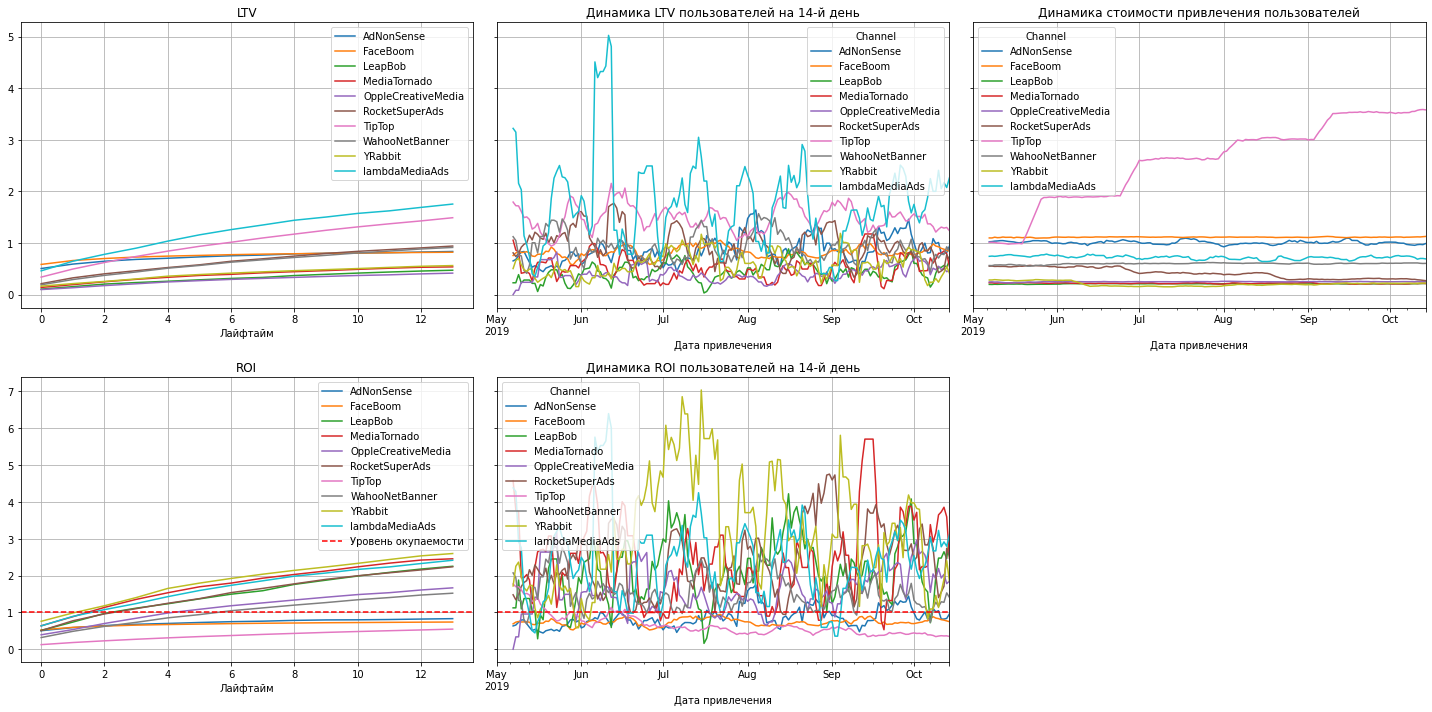

In [48]:
dimensions = ['Channel']
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

LTV выше всего у lambdaMediaAds. Динамика стоимости привлечения пользователей растет только у TipTop. Затраты на рекламу в каналах TipTop, FaceBoom, AdNonSense не окупаются.

Реклама в целом не окупается.
Негативное влияние на окупаемость рекламы оказывают пользователи устройств Android, MAC, iPhone. 
Реклама для пользователей США также не окупается.
Затраты на рекламу в каналах TipTop, FaceBoom, AdNonSense не окупаются.

Проблемы могут быть вызваны техническими сложностями установки приложения на устройствах Android, MAC, iPhon. 
Необходимо пересмотреть затраты по каналам. TipTop, FaceBoom занимают 82,7% расходов на рекламу. Можно рекомендовать присмотреться повнимательнее к каналу lambdaMediaAds. Реклама в нем окупается и высокий показатель платящих пользователей (10,5%).


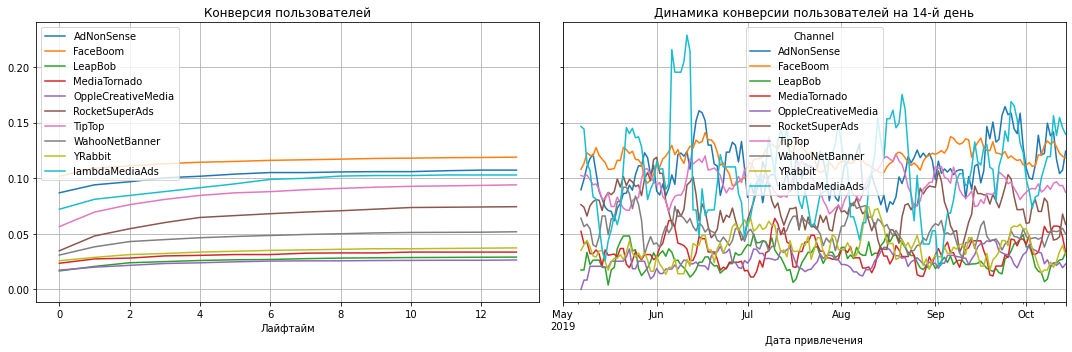

In [49]:
dimensions = ['Channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия пользователей у FaceBoom самая высокая

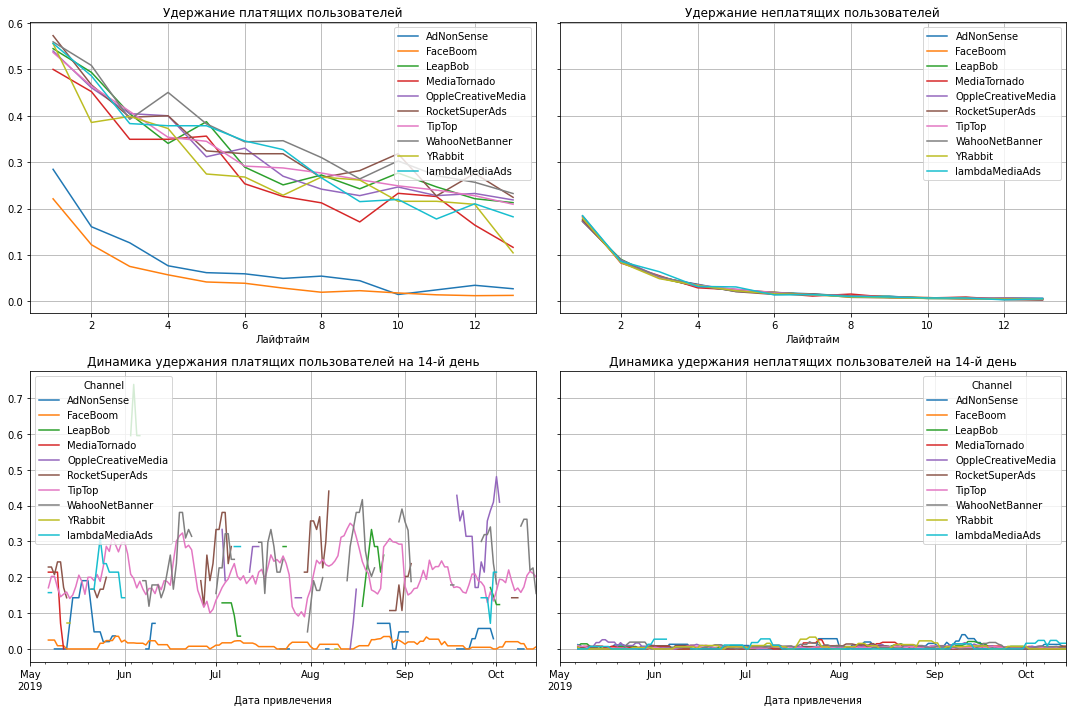

In [50]:
dimensions = ['Channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание платящих пользователей из FaceBoom самое низкое

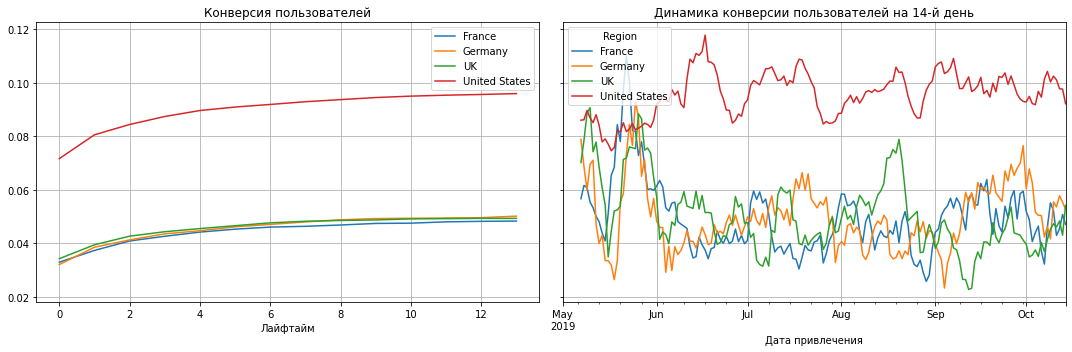

In [51]:
dimensions = ['Region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия пользователей США самая высокая

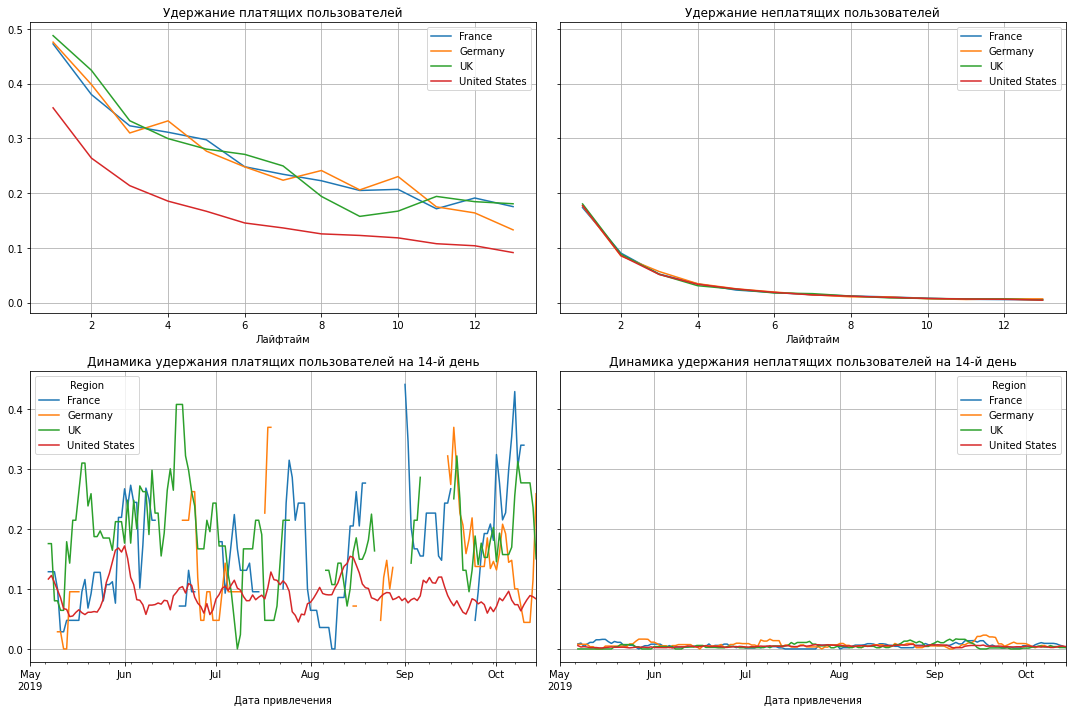

In [52]:
dimensions = ['Region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание платящих пользователей из США самое низкое

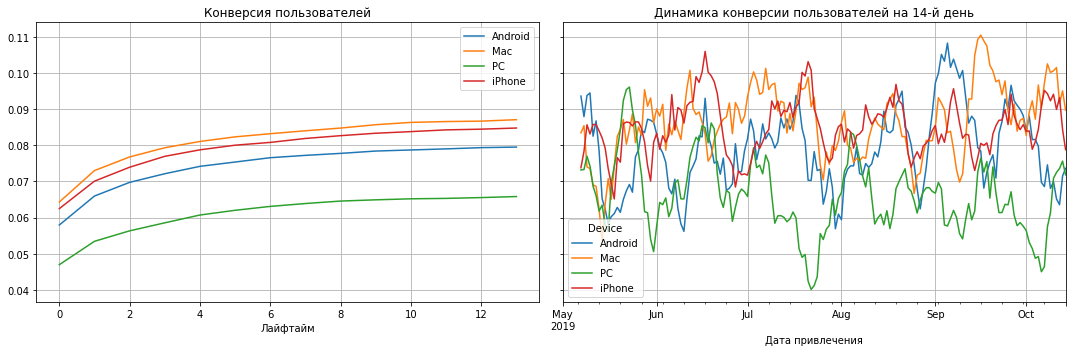

In [53]:
dimensions = ['Device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия выше у Mac, самая низкая у PC.

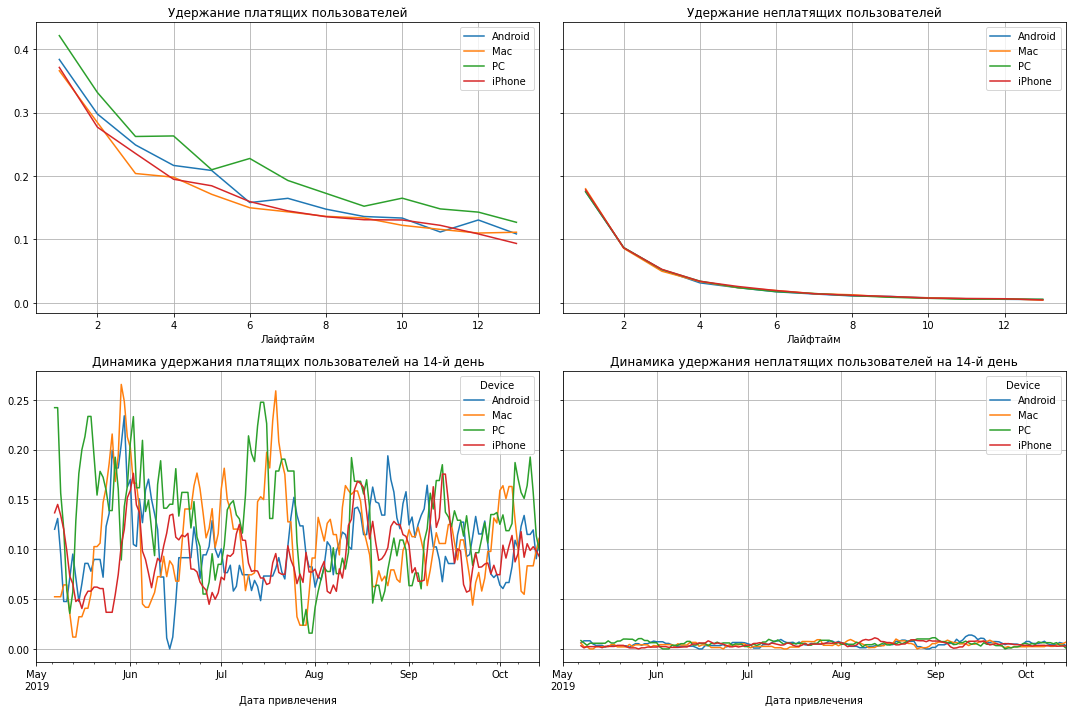

In [54]:
dimensions = ['Device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание платящих пользователей не сильно отличается по устройствам. Выше всего у РС.

### Выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

Начиная с июня 2019г. реклама перестала окупаться. Три канала с рекламой не окупились: TipTop, FaceBoom, AdNonSense. 82,7% затрат на рекламу - это реклама на каналах TipTop, FaceBoom. 
Реклама для пользователей США также не окупается. 
Пользователи с устройствами Android, MAC, iPhone не окупаются.

Рекомендации:
1. Пересмотреть затраты на рекламу по каналам. Снизить затраты на TipTop, FaceBoom. Возможно усилить рекламу на канале lambdaMediaAds
2. Усилить рекламную компанию в Германии, Франции и Великобритании.
3. Проанализировать май-июнь 2019г. на предмет экономического или политического события, повлекшего снижение окупаемости.
4. Выявить технические сложности, с которыми сталкиваются пользователи на устройствах Android, MAC, iPhonе.